In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

SAMPLE_IMAGE = './RGB.byte.jpg'

# Module 4: Raster processing in Python

## GIS in Python

There has been a lot of growth in Python packages recently associated with spatial analysis
* Traditional GIS vendors like esri, QGIS have created APIs to expose functionality:
  * esri (`arcpy`)
  * QGIS (`pyqgis`)
* New geospatial companies are porting workflows to Python:
  * Mapbox (`rasterio`)
  * Stamen Design (`tilestache`)
  * DigitalGlobe 
* Google Earth Engine has Python API for massive cloud-based raster processing
  * `earthengine-api`

## Vector packages
While we won't focus on vector-based analysis in this module, there are a number of great packages for vector-based processing
* `ogr` within `osgeo`
* `fiona`
* `shapely`
* `geopandas`
* `arcpy`

## Raster packages in this module: `arcpy` and `rasterio`

We'll be looking at two different Python raster packages for this module:
* `arcpy`: Python API for ArcGIS (closed-source)
* `rasterio`: A 'pythonic' port of GDAL functionality (open-source)

My advice for usage:
* If you want a fully-functional raster analysis library with low barrier to entry, go with `arcpy`
* If you want full control over raster cell processing (e.g. custom modeling), go with `rasterio`

## Foundational elements: GDAL and `numpy`
* GDAL (C/C++): Translator library for raster and vector geospatial data formats with some utility functions
  * used for I/O of "serialized" data into memory
* numpy (Python): Fundamental package in the scientific stack of Python tools for array manipulation.
  * used as the in-memory representation of raster data
  
Because this workshop is focused on "user-facing" packages, GDAL and numpy don't get enough credit for being the engines that drive this functionality.

## The two-minute introduction to `numpy`
* For the purposes of this lab, think of numpy arrays as data cubes (3-D) of the same data type.
  * Axis 0 in a numpy array = "bands" in a raster
  * Axis 1 in a numpy array = "rows" in a raster
  * Axis 2 in a numpy array = "columns" in a raster
* For single band images, we only have "rows" by "columns", so a 2-D array
  * Axis 0 = "rows"
  * Axis 1 = "columns"
* Indexing for numpy arrays is integer based with commas separating axes and colons designating slices

In [37]:
# Create a range of numbers from 0-23 into a one-dimensional numpy array
arr = np.arange(24)
print(arr)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [38]:
# Reshape this array into a 3-D array with 2 "bands", 3 "rows", and 4 "columns
# This simulates a two band raster
arr_3d = arr.reshape((2, 3, 4))
print(arr_3d)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [41]:
# Get the first band
print(arr_3d[0,:,:])

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


In [42]:
# Get the last band
print(arr_3d[-1,:,:])

[[12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]


In [40]:
# Get the two bands at the top left corner
print(arr_3d[:,0,0])

[ 0 12]


In [43]:
# Get the two bands at the bottom right corner
print(arr_3d[:,-1,-1])

[11 23]


## arcpy
* Very large library of GIS functionality (vector, raster, cartography, data management, etc.)
* Most of `arcpy` *raster* functionality within Spatial Analyst toolbox and module (`arcpy.sa`)
* Need to "check out" Spatial Analyst extension before using
* Typically need to set up a workspace before processing
* Rasters need to be saved out using the `save` method

In [2]:
# Typical set up for arcpy environment
import arcpy
from arcpy import sa     # Spatial Analyst extension
from arcpy import env    # Environmental settings

# Check out extension
arcpy.CheckOutExtension('Spatial')

# Set up workspace
env.workspace = '.'

# Set up scratch workspace
env.scratchWorkspace = 'c:/temp'

# Allow overwriting - BE CAREFUL!!!!
env.overwriteOutput = True

## arcpy - sample functionality 

Using the `sa.Con` method - equivalent to `if DEM > 1000, set equal to 1, else set to 0`

In [3]:
out = sa.Con('./dem.tif', 1, 0, 'value > 1000')
out.save('./dem_con.tif')

Using the `sa.Slope` method - Calculating slope percent of a raster

In [4]:
out = sa.Slope('./dem.tif')
out.save('./slope_percent.tif')

Using the `sa.Compbine` method - Combining two rasters together - each combination is a new value in the output raster

In [5]:
out = sa.Combine(['./dem_con.tif', './slope_percent.tif'])
out.save('./combine.tif')

Dozens more functions exist - see http://desktop.arcgis.com/en/arcmap/10.5/tools/spatial-analyst-toolbox

## arcpy - in-chain processing

Instead of saving out a number of intermediate rasters, functions can be chained together to create output.  This is the same output as before, but only writing out the final raster.

In [6]:
con_raster = sa.Con('./dem.tif', 1, 0, 'value > 1000')
slope_raster = sa.Slope('./dem.tif')
combine_raster = sa.Combine([con_raster, slope_raster])
combine_raster.save('./combine_2.tif')

Or even more succinctly:

In [7]:
sa.Combine([
    sa.Con('./dem.tif', 1, 0, 'value > 1000'),
    sa.Slope('./dem.tif')
]).save('./combine_3.tif')

## arcpy - complex raster algebra

When we create a statement like `slope_raster = sa.Slope('./dem.tif')`, we are actually creating a temporary raster object.  We can use this to create complicated raster expressions with normal operators.  This following example creates three 5-class rasters based on natural breaks (DEM, aspect, and slope) and creates an algebraic expression so that each digit in the output raster represents a different class.

In [8]:
slope_class = sa.Slice(sa.Slope('./dem.tif'), 5, 'NATURAL_BREAKS')
asp_class = sa.Slice(sa.Aspect('./dem.tif'), 5, 'NATURAL_BREAKS')
dem_class = sa.Slice('./dem.tif', 5, 'NATURAL_BREAKS')
out = (slope_class + (asp_class * 10) + (dem_class * 100))
out.save('combined_topography.tif')

Or even more succinctly:

In [9]:
(
    sa.Slice(sa.Slope('./dem.tif'), 5, 'NATURAL_BREAKS') + 
    sa.Slice(sa.Aspect('./dem.tif'), 5, 'NATURAL_BREAKS') * 10 +
    sa.Slice('./dem.tif', 5, 'NATURAL_BREAKS') * 100
).save('combined_topography_2.tif')


## arcpy - working with numpy arrays
There may be times when your spatial processing task is too complicated for existing functionality within ArcGIS.  In those cases, `arcpy` allows conversion to/from rasters to `numpy` arrays using two methods:
* arcpy.RasterToNumPyArray
* arcpy.NumPyArrayToRaster

Here's an example to calculate the percentage contribution of each cell to the row's total, something not simple to do with ArcGIS functionality

In [10]:
# Convert from raster to numpy array
arr = arcpy.RasterToNumPyArray('./dem.tif')

# Calculate row totals and reshape to 2-D array
row_sums = arr.sum(axis=1).reshape((-1, 1))

# Calculate cell contributions to row totals
prop_cell = (1.0 * arr) / row_sums

# Recast as raster and save
arcpy.NumPyArrayToRaster(prop_cell).save('prop_cell.tif')

## rasterio

* fairly new package (2013)
* in contrast to `arcpy`, `rasterio` more tightly couples with both GDAL and `numpy`
* thin wrapper around the GDAL C/C++ library, mostly using its functionality for raster reading and writing
* very much a lower-level interface to raster data - no raster analysis functions built in

## rasterio - reading in data
This is very similar to `arcpy.RasterToNumPyArray` functionality.  The `pixel_values` object in the code below is a `bands x rows x cols` numpy array.

In [11]:
import rasterio
src = rasterio.open(SAMPLE_IMAGE)
pixel_values = src.read()
print(type(pixel_values))
print(pixel_values.shape)

<type 'numpy.ndarray'>
(3, 718, 791)


c:\users\gregorma\envs\default\lib\site-packages\rasterio\__init__.py:249: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


Reading in only one band of data - return value is a `rows x cols` numpy array

In [12]:
# Warning - bands are 1-indexed, numpy arrays are 0-indexed
pixel_values_band = src.read(1)
print(type(pixel_values_band))
print(pixel_values_band.shape)

<type 'numpy.ndarray'>
(718, 791)


## rasterio - reading in metadata

`rasterio` holds all metadata associated with a raster in the `profile` attribute.  Notice that this particular dataset has no coordinate reference system (`crs`).

In [13]:
# Print out all keys/values of the profile
for k, v in src.profile.items():
    print(k, ':', v)
    
# Dimensions of data - rows x columns
print('-' * 50)
print('Rows, columns: ', src.height, src.width)

count : 3
crs : None
interleave : pixel
dtype : uint8
photometric : ycbcr
driver : JPEG
transform : | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
height : 718
width : 791
tiled : False
nodata : None
compress : jpeg
--------------------------------------------------
Rows, columns:  718 791


## rasterio - iterating over raster "blocks"
One advantage of `rasterio` (over `arcpy`) for fine control of spatial processing and memory management is the concept of raster blocks.  Instead of reading an entire raster into memory all at once, `rasterio` provides an way to "iterate" over all the "blocks" in a raster.  Blocks are sections in a raster that are contiguous in a file system, so reading data naturally by blocks avoids unnecessary scans on a file.  It also allows for parallel processing of different raster blocks.

In [14]:
# Figure out the natural block size for an image
block_windows = src.block_windows(1)

# Iterate over these block windows and print out a
# small subarray of the returned numpy array
# The `ji` value is the row and column index of this block
# In this case, each block is a row of data
for ji, window in block_windows:
    r = src.read(1, window=window)
    print(ji, r[0, 300:304])

(0, 0) [0 0 0 0]
(1, 0) [0 0 0 0]
(2, 0) [0 0 0 0]
(3, 0) [0 0 0 0]
(4, 0) [0 0 0 0]
(5, 0) [0 0 0 0]
(6, 0) [0 0 0 0]
(7, 0) [0 0 0 0]
(8, 0) [0 0 0 0]
(9, 0) [0 0 0 0]
(10, 0) [0 0 0 0]
(11, 0) [0 0 0 0]
(12, 0) [0 0 0 0]
(13, 0) [0 0 0 0]
(14, 0) [0 0 0 0]
(15, 0) [0 0 0 0]
(16, 0) [0 0 0 0]
(17, 0) [0 0 0 0]
(18, 0) [0 0 0 0]
(19, 0) [0 0 0 0]
(20, 0) [0 0 0 0]
(21, 0) [0 0 0 0]
(22, 0) [0 0 1 1]
(23, 0) [0 0 1 1]
(24, 0) [0 2 1 1]
(25, 0) [0 0 1 1]
(26, 0) [5 0 0 0]
(27, 0) [0 0 2 0]
(28, 0) [254 250   2   1]
(29, 0) [254 254 252 255]
(30, 0) [250 254 255 255]
(31, 0) [252 250 254 232]
(32, 0) [251 241 252 251]
(33, 0) [217  68 251  80]
(34, 0) [ 23  14  15 190]
(35, 0) [ 32  16  15 117]
(36, 0) [20  8 14 14]
(37, 0) [10 12  5 10]
(38, 0) [11  9  8  8]
(39, 0) [ 7  1  3 98]
(40, 0) [ 5 10 56 83]
(41, 0) [11  3 11  8]
(42, 0) [9 4 9 6]
(43, 0) [6 5 8 8]
(44, 0) [11  9  5  4]
(45, 0) [ 6  5  5 11]
(46, 0) [6 9 5 5]
(47, 0) [ 3 10  9  9]
(48, 0) [ 9 12  8 14]
(49, 0) [119  45  50  72

(696, 0) [0 0 0 0]
(697, 0) [0 0 0 0]
(698, 0) [0 0 0 0]
(699, 0) [0 0 0 0]
(700, 0) [0 0 0 0]
(701, 0) [0 0 0 0]
(702, 0) [0 0 0 0]
(703, 0) [0 0 0 0]
(704, 0) [0 0 0 0]
(705, 0) [0 0 0 0]
(706, 0) [0 0 0 0]
(707, 0) [0 0 0 0]
(708, 0) [0 0 0 0]
(709, 0) [0 0 0 0]
(710, 0) [0 0 0 0]
(711, 0) [0 0 0 0]
(712, 0) [0 0 0 0]
(713, 0) [0 0 0 0]
(714, 0) [0 0 0 0]
(715, 0) [0 0 0 0]
(716, 0) [0 0 0 0]
(717, 0) [0 0 0 0]


## Displaying images in Jupyter using rasterio
Often, when working in Jupyter we don't want to have to be switching on and off between Jupyter and (e.g.) ArcGIS to visualize our output.  We can use some simple image display functionality from `matplotlib` to visualize intermediate products easily.  

Here we are going to create two functions to display a single band raster and a three-band RGB raster.  We will be able to call them after we've defined them.  These won't make a lot of sense right now (until the graphics module), so we'll skip over them quickly.

In [15]:
# Create a function to display a single-band image using
# the specified colormap.  For information on matplotlib colormaps
# see this page: https://matplotlib.org/users/colormaps.html
def display_band(image, band=0, cmap=cm.gray):
    # Extract the band from the image
    if len(image.shape) == 2:
        arr = image
    else:
        arr = image[band]
    
    # Set the plot figure size
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # Show the image
    im = ax.imshow(arr, cmap=cmap, interpolation='none')

    # Show a corresponding colorbar
    fig.colorbar(im);
    
# Create a function to display a three-band image in RGB
def display_rgb(image, bands=[2, 1, 0]):
    assert(image.shape[-1] == 3)
    
    # Set the plot figure size
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # Show the image
    im = ax.imshow(image)
    
# Function to move the first axis to the end
def move_axis(arr, from_axis=0, to_axis=-1):
    return np.moveaxis(arr, from_axis, to_axis)    

## arcpy - displaying images in Jupyter

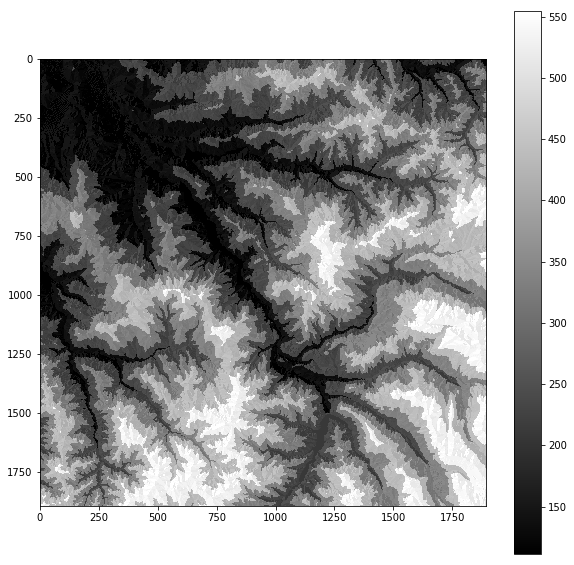

In [46]:
# Convert raster to a numpy array
arr = arcpy.RasterToNumPyArray('./combined_topography.tif')

# Display this band as a matplotlib image
# Trim off the edge rows/columns - some bug I haven't figured out
display_band(arr[1:-1, 1:-1])

## rasterio - displaying images in Jupyter
We can visualize our `rasterio` rasters (really `numpy` arrays at this point) using these new functions.  Because the sample raster that we are using is relatively small, we can read the whole raster into memory (called `pixel_values`).

This shows the first band of the 3-D numpy array.

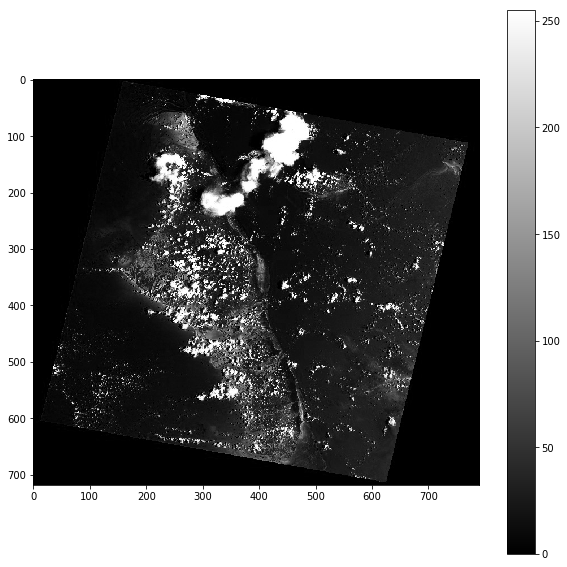

In [20]:
pixel_values = src.read()
display_band(pixel_values, band=0)

This shows the RGB of the image, but we first have to move the first axis to the last using the `move_axis` function

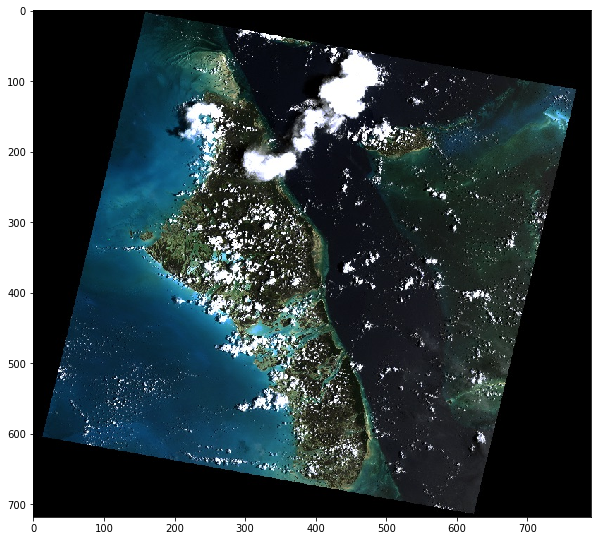

In [21]:
display_rgb(move_axis(pixel_values))

Because we can slice a numpy array, we can also show subwindows of the raster.  Here we show the RGB image for rows and columns 400-600.

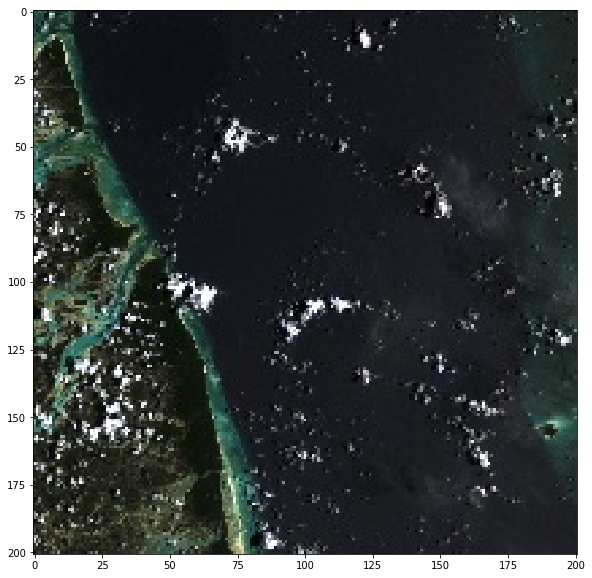

In [22]:
subset = pixel_values[:, 400:601, 400:601]
display_rgb(move_axis(subset))

## Exercises

### Exercise #1: Site selection analysis for solar farm (part 1)

**Task**: Conduct a site-suitability analysis to situate a solar farm in the Willamette Valley.  The first step of the analysis will be to use topographic variables to find suitable gentle SW-facing slopes.

Conditions:
1. Sites must be between 50m and 700m in elevation
2. Sites must be between 5 and 20 percent slopes
3. Sites must have aspects between 170 and 280 degrees 
4. Sites must be at least 400 contiguous acres

Source Data:
* Digital elevation model (`site_dem.tif`) 

**Note**: You have already imported the `sa` module from `arcpy`, so you can use this module throughout this exercise.  

First create a slope raster based on the DEM, using the `sa.Slope` function and call the output `slope`.  Remember that you can type `sa.Slope` then hit `Shift+Tab` to get the calling signature.

In [23]:
# Create a slope grid based on the DEM
slope = sa.Slope('site_dem.tif')

Create an aspect raster based on the DEM using the `sa.Aspect` function and call the output `aspect`.

In [24]:
# Create an aspect grid based on the DEM
aspect = sa.Aspect('site_dem.tif')

Now we want to identify areas that meet our first three conditions.  We will use the `sa.SetNull` function to perform this.  The `sa.SetNull` command takes an input raster and sets all output cells to NODATA where the specified logic is true, and to a specified value where the specified logic is false.  Consider this example:
```
where_clause = 'VALUE > 100'
output = sa.SetNull(input, 1, where_clause)
```
This would look at the `input` raster and where the `VALUE` of the raster is greater than 100, it would be NODATA in `output`.  Where the raster is less than or equal to 100, the `output` value would be `1`.  

So if we want to find an elevation value that is between 50 and 700m, we actually need to look for values that are outside that range so that they get set to NODATA.  We want the 'good' elevation values to be set to `1`.  So for the first condition, we'll use this statement:
```
where_clause = 'VALUE < 50 OR VALUE > 700'
good_dem = sa.SetNull('site_dem.tif', 1, where_clause)
```
Paste this in to the cell below and evaluate it.

Now we want to create favorable conditions for slope and aspect.  Create a raster called `good_slope` that is `1` where `slope` (the slope raster you created a few steps ago) is between 5 and 20 and NODATA otherwise.

In [25]:
# Slope between 5% and 20%
where_clause = 'VALUE < 5 OR VALUE > 20'
good_slope = sa.SetNull(slope, 1, where_clause)

Do the same for `aspect` between 170 and 280 and call the output `good_aspect`.

In [26]:
# Aspect between 170 and 280
where_clause = 'VALUE < 170 OR VALUE > 280'
good_aspect = sa.SetNull(aspect, 1, where_clause)

At this point, we need to combine all three rasters (`good_dem`, `good_slope` and `good_aspect`) to find where all three are equal to 1.  Where any raster is NODATA, the output will also be NODATA.  We use the `sa.Combine` function and set its argument to a Python list of our inputs: `good_dem`, `good_slope` and `good_aspect`.  Call this output `good_combine`.

In [29]:
# Combine these together
good_combine = sa.Combine([good_dem, good_slope, good_aspect])

Now we need to group these suitable pixels into contiguous patches.  We use the `sa.RegionGroup` function to do this.  The `sa.RegionGroup` function will take our `good_combine` raster as its first argument.  The second argument is a string ('FOUR' or 'EIGHT') that specifies how patches are defined.  'FOUR' means that contiguous pixels can be edge neighbors, whereas 'EIGHT' means that contiguous pixels can be corner neighbors.  We'll use 'FOUR' for our call.

Call the output `regions`.

In [30]:
# Group the unique regions together to find contiguous parcels
regions = sa.RegionGroup(good_combine, 'FOUR')

We're nearly done.  We just have to filter these regions to those that are at least 400 acres in size.  Each integer raster in Arc Grid format has at least 'VALUE' and 'COUNT' columns in its attribute table.  When we created the regions, each region has a unique number and the 'COUNT' column retains how many pixels are in that region.  First let's define a conversion factor that goes from acres to pixels (assuming 30m pixels).  Go ahead and evaluate the below cell:

In [32]:
# Filter out regions less than 400 acres 
MIN_ACRES = 400
ACRES_TO_HECTARES = 0.4047
HECTARES_TO_PIXELS = 10000 / 900 
MIN_PIXELS = int(MIN_ACRES * ACRES_TO_HECTARES * HECTARES_TO_PIXELS)

Now you will use the `sa.SetNull` function to find all regions greater than `MIN_PIXELS`.  We actually want the region number out (instead of 1 as in previous examples).  Our where clause is going to be:
```
where_clause = 'COUNT < ' + str(MIN_PIXELS)
```
Try to write the `sa.SetNull` function call using `regions` as input.  Call the ouput of this command `large_regions`.

In [33]:
where_clause = 'COUNT < ' + str(MIN_PIXELS)
large_regions = sa.SetNull(regions, regions, where_clause)

Save this raster out as a GeoTiff by evaluating the following cell.  If you have time, open ArcMap and bring in the original dem (`site_dem.tif`) and the region raster you just created (`large_regions.tif`) to see what regions were identified.

In [34]:
large_regions.save('large_regions.tif')

### Exercise #2: Site selection analysis for solar farm (part 2)
We also want to base our solar farm sites based on distance from urban centers.  Solar farms will serve large metropolitan areas, but be sited on lands outside urban growth boundaries.

Conditions:
1. Sites must be at least 8km but no greater than 20km from an urban center

Source Data:
* National Land Cover Dataset 2001 (`site_nlcd.tif`) to identify urban areas

**Note**: This section is just presented as a walkthrough (nothing to answer!).  Just step through the evaluation cells and try to understand the syntax of what is happening.  At any point, you can export an intermediary raster by calling its `.save` method and giving it an output name as its only argument.

Make a grid of urban areas from NLCD grid (codes 23 and 24) and set all unmapped values to NODATA


In [35]:
urban = sa.ReclassByASCIIFile('site_nlcd.tif', 'cities.txt', 'NODATA')

Get rid of 'spurious' urban pixels by shrinking zones

In [36]:
urban_core = sa.Shrink(urban, '3', '1')

Now that we've defined urban centers, find Euclidean distance from each city

In [37]:
urban_euc_dist = sa.EucDistance(urban_core)

Find the mean distance from an urban_core pixel for each candidate region

In [38]:
mean_dist = sa.ZonalStatistics(large_regions, 'VALUE', urban_euc_dist, 'MEAN', 'DATA')

Convert the mean_dist raster to an integer raster to ensure the grid has an attribute table

In [39]:
mean_dist_int = sa.Int(mean_dist)

Choose a site between 8 and 20 km (mean distance) away from an urban center

In [40]:
where_clause = 'VALUE <= 8000 OR VALUE >= 20000'  
good_large_regions = sa.SetNull(mean_dist_int, large_regions, where_clause)

Extract the NLCD data associated with these sites so that we can evaluate the land cover types and export this

In [41]:
nlcd_sites = sa.ExtractByMask('site_nlcd.tif', good_large_regions)
nlcd_sites.save('candidates_nlcd.tif')

Convert the `good_large_regions` raster to polygons.  If you want, preview both `candidates_sites.shp` and `candidates_nlcd.tif` layers within ArcMap.

In [42]:
from arcpy import conversion
conversion.RasterToPolygon(good_large_regions, 'candidates_sites.shp', 'NO_SIMPLIFY')

<Result '.\\candidates_sites.shp'>

### Exercise #3: Use `arcpy` to calculate difference in normalized burn ratio (dNBR) using numpy arrays
This is an example of using `arcpy`'s ability to convert raster data to numpy arrays to calculate the difference in the normalized burn ratio for the recent Chetco Fire in Southwest Oregon.  Again, this is a step-through to show how you might perform such an analysis.

First set up a function so that we can visualize the pre- and post-fire imagery.  This function extracts three bands from the orginal six, normalizes each band based on its minimum/maximum values and displays it within the Jupyter notebook.  Evaluate this cell to define this function.

In [51]:
def display_chetco_rgb(arr, bands=[2, 1, 0]):
    # Get the requested bands and convert to floating point
    new_arr = arr[bands,:,:].astype(np.float)
    
    # Normalize a 2-D band based on minimum/maximum values
    def normalize(a):
        a_min, a_max = a.min(), a.max()
        return (a - a_min) / (a_max - a_min)
    
    # Normalize the bands to [0-1]
    for band in range(3):
        new_arr[band,:,:] = normalize(new_arr[band,:,:])
        
    # Display the image as an RGB image
    display_rgb(move_axis(new_arr))

Convert both the pre- and post-fire rasters to numpy arrays using `arcpy.RasterToNumPyArray`.

In [52]:
# Convert rasters to a numpy array
chetco_pre = arcpy.RasterToNumPyArray('./chetco_pre.tif')
chetco_post = arcpy.RasterToNumPyArray('./chetco_post.tif')

Now, display both of these in the notebook using the function we just defined

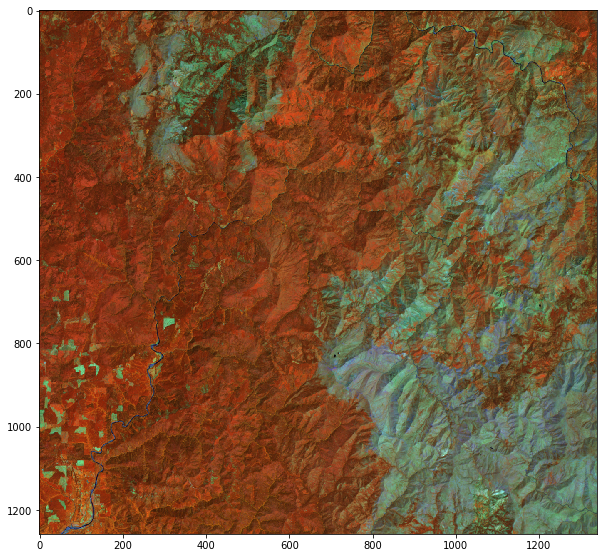

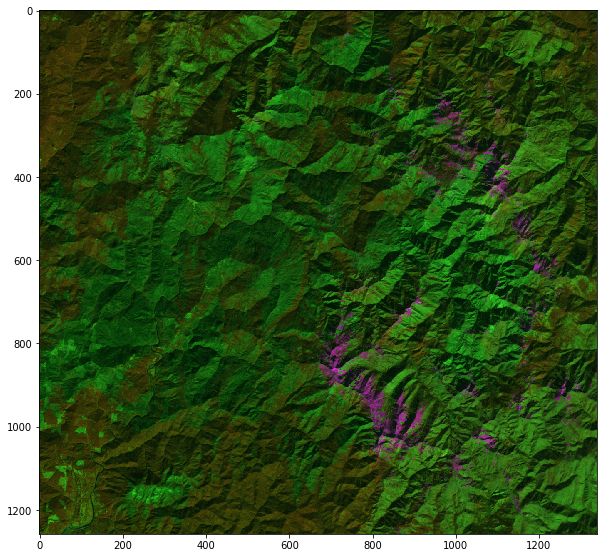

In [54]:
display_chetco_rgb(chetco_pre, bands=[3, 4, 2])
display_chetco_rgb(chetco_post, bands=[3, 4, 2])

Calculate NBR as a ratio of bands 4 and 7 for the pre-fire image.  In our stack, we have the following mapping of TM bands to indexes:
```
Index | Band
------------
    0 | Band 1
    1 | Band 2
    2 | Band 3
    3 | Band 4
    4 | Band 5
    5 | Band 7
```

So we want to use the slices 3 and 5 on the first axis of our numpy array.  Using the syntax `chetco_pre[0,:,:]` would give us all rows and columns of Band 1.  NBR is defined as `(B4 - B7) / (B4 + B7)`.



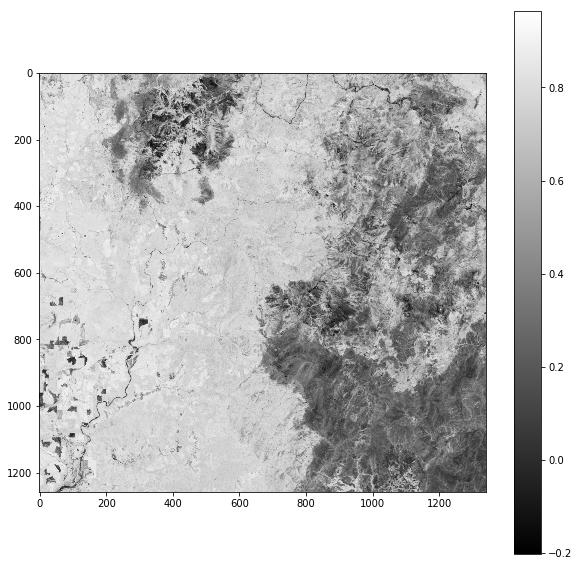

In [55]:
# Get pre-fire NBR surfaces
b4_pre = chetco_pre[3,:,:]
b7_pre = chetco_pre[5,:,:]
nbr_pre = (b4_pre - b7_pre).astype(np.double) / (b4_pre + b7_pre)
display_band(nbr_pre)

Do the same with post-fire NBR:

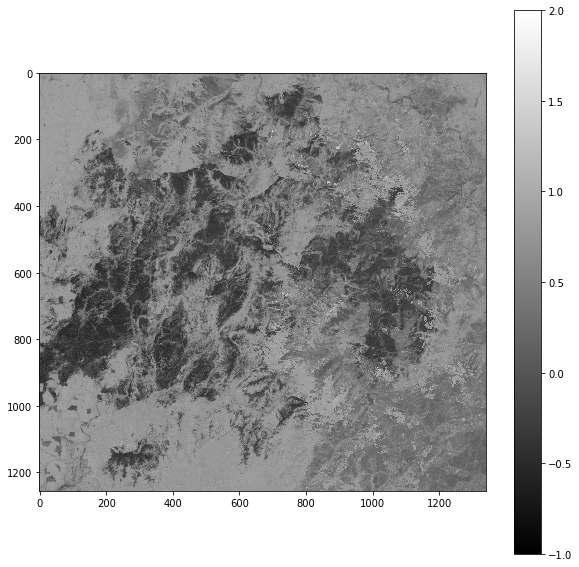

In [56]:
b4_post = chetco_post[3,:,:]
b7_post = chetco_post[5,:,:]
nbr_post = (b4_post - b7_post).astype(np.double) / (b4_post + b7_post)
display_band(nbr_post)

Finally difference the two NBR rasters - pre-fire minus post-fire

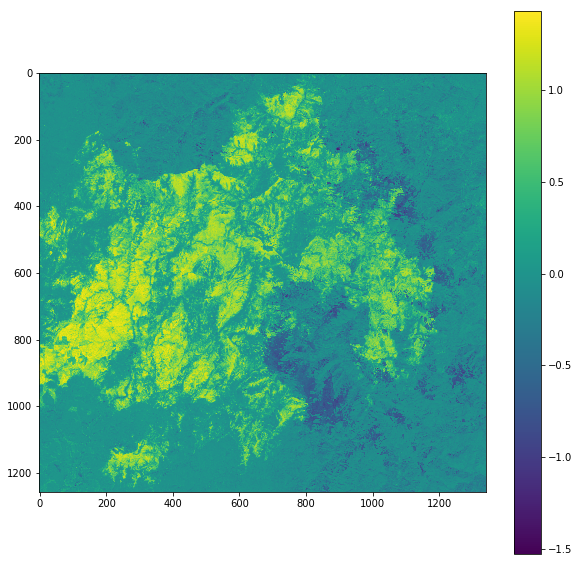

In [57]:
# Difference them
nbr_diff = nbr_pre - nbr_post
display_band(nbr_diff, cmap='viridis')

Convert this back to an Arc raster and save it out:

In [49]:
arcpy.NumPyArrayToRaster(nbr_diff).save('chetco_nbr_diff.tif')